In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():   
  
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.is_available()
torch.cuda.get_device_name()
torch.cuda.current_device()
t = torch.cuda.get_device_properties(0).total_memory/1024/1024/1024
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
print(t, c, a)

There are 1 GPU(s) available.
We will use the GPU: Quadro P2000
5.0 0 0


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
import re
from scipy import stats

import os
os.chdir("I:")

from tqdm.notebook import tqdm
tqdm.pandas()

C:\Users\Insight1\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Vectorize notes by Spacy

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
df = pd.read_pickle('spacy_vec_split_len.pkl')

In [ ]:
import string
def clean2(note):
    table = str.maketrans('', '','!"#$%&\'()*+,-./:;<=>?@‘¥£’—“[\\]^_`{|}~«»§é')
    s = note.translate(table)
    s1 = s.replace('\n',' ').lower()
    s2 = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s1)
    st_clean = re.sub(r' +', ' ', s2)
    return st_clean

In [ ]:
df['notes_clean'] = df['notes'].progress_apply(lambda x: clean2(x))

df['len_clean'] = df['notes_clean'].progress_apply(lambda x: len(x.split(' ')))

df[['key','notes','le_months','notes_clean','len_clean']].to_pickle('notes_clean.pkl')

In [ ]:
df['noteclean_spacy_vec'] = df['notes_clean'].progress_apply(lambda x: nlp(x).vector)

df[['notes_clean','noteclean_spacy_vec','le_months']].to_pickle('clean_note_spacy_vec.pkl')

In [ ]:
filt = (df['len_clean']<=2000) & (df['len_clean']>=100) & (df['le_months'] <=250)
df[filt]

In [ ]:
df['note_spacy_vec'] = df['notes'].progress_apply(lambda x: nlp(x).vector)

df.to_pickle('spacy_vec.pkl') #save Spacy vectorized notes to pkl

In [ ]:
df['le_months'] = df['le_months'].astype(int)
print(df.dtypes)

print(df['le_months'].astype(int).min())
print(df['le_months'].astype(int).max())

ave_mo = np.average(df['le_months'].to_numpy())
mode_mo = stats.mode(df['le_months'].to_numpy())
print('Months to live Average: {} \nMonths to live mode: {}'.format(ave_mo, mode_mo[0]))


## Save spacy_vec, note_split, len_word as pickle

In [ ]:
#df['len_char'] = df['notes'].apply(len)
df['note_split'] = df['notes'].str.replace('\n', '').str.replace(r' +', ' ').str.split(' ') #replace \n with space or not
df['len_word'] = df['note_split'].apply(len)

df.to_pickle('spacy_vec_split_len.pkl') #save Spacy vectorized notes to pkl

## Load spacy_vec_split_len.pkl

In [ ]:
# df = pd.read_pickle('spacy_vec_split_len.pkl')
# type(df['note_split'][0])

In [ ]:
df['note_spacy_vec'].apply(len)

## Plot life expectancy

In [ ]:
#df[['le_months']].plot(kind='hist',bins=[0,100, 200, 400],rwidth=0.8)
plt.hist(df['le_months'].to_numpy(), bins = 50, color = 'gold', ec = 'black')
plt.xlabel('Month', fontsize =12)
plt.ylabel('Frequency',fontsize =12)
plt.title('Remaining Life Expectancy  Distribution')
# plt.grid(True)

## Plot number of words per note

In [ ]:
# df[['len_word']].plot(kind='hist',bins=[0,100, 1000, 5000, math.inf],rwidth=0.8)
plt.hist(df['len_word'].to_numpy(), bins = 50, color = 'pink', ec = 'black')
plt.xlabel('Words Per Note',fontsize =12)
plt.ylabel('Frequency',fontsize =12)
plt.title('Number of Words per Note')#### Plot life expectancy

## Data Cleaning

In [ ]:
print(df.shape)

df.drop(index = df[(df['len_word'] <=2) | (df['len_word']>= 2000)].index, inplace = True) # remonve empty or >2000 note
df.drop(index = df[df['le_months']>250].index, inplace = True) # remove life expect > 250 mo (21 years)
# above total removed 706 data
print(df.shape)

## Plot note Word cloud

In [ ]:
df = pd.read_pickle('spacy_vec_split_len.pkl')

In [ ]:
filt = (df['len_word'] >= 500) & (df['len_word'] <= 600)
notewc = df.loc[filt, 'notes'].copy()
notewc.index = range(len(notewc))

import random
a = random.randrange(len(notewc))

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
STOPWORDS.update(['noted', 'was', 'say','Was','cited','Vv'])
stopwords = set(STOPWORDS)
wc = WordCloud(width = 800, height = 800, 
               background_color ='white', 
               stopwords = stopwords)


wc.generate(notewc[a])
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
wc.to_file('note_wc7.png')

## Train Test Split for ML

In [ ]:
# X and y from noteclean_spacy_vec
filt = df[(df['len_clean']>=100) & (df['len_clean']<=2000) & (df['le_months']<= 250)] # filter data for ML

X = np.array(filt['noteclean_spacy_vec'].values.tolist())
y = filt['le_months'].to_numpy()

In [ ]:
# X and y from note_spacy_vec
filt = df[(df['len_word']>3) & (df['len_word']<=2000) & (df['le_months']<= 250)] # filter data for ML
# filt['len_word'].value_counts().sort_index()

X = np.array(filt['note_spacy_vec'].values.tolist())
y = filt['le_months'].to_numpy()

In [5]:
# X and y from spacy_lss
df = pd.read_pickle('spacy_lss.pkl')
filt = df[(df['len_lss']>50) & (df['len_lss']<=1000) & (df['le_months']<= 250)] # filter data for ML
# filt['len_word'].value_counts().sort_index()

X = np.array(filt['spacy_lss'].values.tolist())
y = filt['le_months'].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Simple ML models based on Spacy vector

In [7]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(reg.score(X_test, y_test)) # R^2 variance weighted

0.4617313122239614


In [ ]:
#Plot y_pred over y_test for linear regression (score = 0.43662885147475616)
#linear reg spacy_lss r2=0.4617313122239614 for 50-1000 len_lss, le_months<250
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot(range(300), range(300), '-r')
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.title("Linear Regression")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [8]:
#xgb regressor r2 score = 0.4118154583805178 for 57k data
#xgb reg spacy_lss r2= 0.44425965934761835  for 50-1000 len_lss, le_months<250

import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
xgb = XGBRegressor().fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
print(r2_score(y_test, y_pred_xgb, multioutput='variance_weighted'))

[08:25:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.44425965934761835


In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot(range(300), range(300), '-r')
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.title("XGBoost Regressor")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [9]:
# random forest regressor score = 0.5402527642512915 for 57k data
# rf regressor r2 = 0.5560166555170266 when filted len_word<=750, le_months<=250
# rf regressor r2 = 0.5384426783146021 when filted 100<=len_word<=2000, le_months<=250 on noteclean_spacy_vec
#rf reg spacy_lss r2= 0.5800088178042535 for 50-1000 len_lss, le_months<250

from sklearn.ensemble import RandomForestRegressor 
reg_rf = RandomForestRegressor(n_estimators = 100, random_state = 0) 
reg_rf = RandomForestRegressor().fit(X_train, y_train)
y_pred_reg_rf = reg_rf.predict(X_test)
y_train_pred = reg_rf.predict(X_train)

print(reg_rf.score(X_test, y_test))

0.5800088178042535


In [15]:
y_train_pred[:100]

array([167.12      , 122.85      ,  33.48      , 100.39      ,
        42.645     ,  58.26166667, 150.86442857,  70.9974127 ,
        81.72      ,  35.87195238,  55.31166667,  40.6055    ,
        93.28      ,  45.40595238, 104.056     , 160.33      ,
        99.996     , 212.32      ,  97.79330952,  41.56666667,
        93.25666667, 102.25      ,  84.98      ,  85.5175    ,
        45.678     ,  72.42      , 152.82      ,  52.35      ,
       115.88      , 156.31      ,  74.3425    ,  77.66045238,
       132.395     , 114.59      ,  37.48      , 129.0337619 ,
       105.14      , 119.24      ,  98.955     , 102.26      ,
        68.91      ,  43.02166667, 100.56      ,  51.98828571,
       126.48738095, 101.42333333,  71.48833333, 118.98      ,
        37.00666667,  76.988     ,  77.45      , 123.54333333,
        87.79952381, 108.08      , 107.23      ,  78.655     ,
       151.58      ,  67.177     , 128.45      ,  76.39014286,
        48.92933333,  83.14      , 148.93      , 101.35

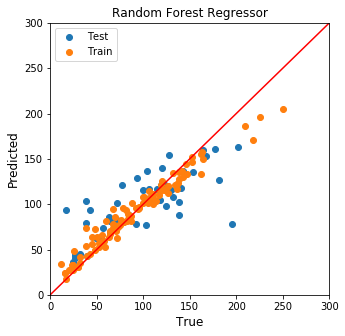

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(y_test[100:150], y_pred_reg_rf[100:150], label = 'Test')
plt.scatter(y_train[100:200], y_train_pred[100:200], label = 'Train')
plt.plot(range(300), range(300), '-r')
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.title("Random Forest Regressor")
plt.xlabel("True",fontsize =12)
plt.ylabel("Predicted",fontsize =12)
plt.legend()
plt.show()

In [ ]:
# BayesianRidge regressor score = 0.4366820387501755, basically the model didn't work. 
# std for predicted label is nearly 60% of predicted value.
from sklearn import linear_model
reg_br = linear_model.BayesianRidge()
reg_br.fit(X_train, y_train)

print(reg_br.score(X_test, y_test))

print(reg_br.predict(X_test[:10], return_std = True))

## LSTM 

In [ ]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm_layer = nn.LSTM(300, 300)
        self.linear_layer = nn.Linear(300, 1)
    def forward(self, input_vec):
        output, _ = self.lstm_layer(input_vec)
        logit = self.linear_layer(output.view(len(input_vec), -1))
        return logit

In [ ]:
model = lstm()
print(model)

for p in model.named_parameters():
    print(p[0], str(tuple(p[1].size())))

In [ ]:
model.to(device)
criterion = nn.L1Loss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

## Encode Text into 510 per group for BERT input

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
def text_to_idmtx(note):
    ids = tokenizer.encode(note, add_special_tokens = False)
    idmtx = [[101]+ids[i:i+510]+[102] for i in range(0, len(ids), 510)]
    idmtx[-1] += (512-len(idmtx[-1]))*[0]
    idmtx = np.array(idmtx).reshape(-1, 512)
    return idmtx

In [ ]:
df['len_token_id'] = df['token_id'].progress_apply(len)

In [ ]:
df['token_id_matrix'] = df['notes'].progress_apply(text_to_idmtx)

In [ ]:
# df[['key','notes', 'le_months', 'note_spacy_vec', 'bert_token_id','token_id_matrix']].to_csv('note_vec_token.csv', index = False)

df[['key','notes', 'le_months', 'note_spacy_vec','token_id_matrix']].to_pickle('note_vec_token.pkl')

In [ ]:
def k_row(mtx, k=6):
    row = mtx.shape[0]
    if row <= k:
        n = 512*(k-row)
        mtx_new = np.append(mtx.reshape(1, -1), [0]*n)
    else:
        mtx_new = np.squeeze(mtx.reshape(1,-1))[: k*512]
    return mtx_new


df['six_row'] = df['token_id_matrix'].progress_apply(k_row)

In [ ]:
df['six_row'].apply(len).value_counts()

## BERT X & y

In [ ]:
dfbert = df[df['le_months'] <= 250]
X = np.array(dfbert['six_row'].tolist()).astype(np.int64)
y = dfbert['le_months'].astype(np.float32).to_numpy()

mask = (X!=0).astype(np.int8)

In [ ]:
X.dtype

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import datetime
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import  AutoTokenizer, AutoModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
def dataLoader(input_ids, input_mask, labels, batch_size=32, val_test_size=0.1, random_seed=2020):
  """This function takes in all available data, split into train, val, test, and return a torch DataLoader for each. 
  """
  # split into train, validation, test 
  X_train_val, X_test, y_train_val, y_test = train_test_split(input_ids, labels, random_state=random_seed, test_size=val_test_size)
  mask_train_val, mask_test, _, _ = train_test_split(input_mask, labels, random_state=random_seed, test_size=val_test_size)

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=random_seed, test_size=val_test_size)
  mask_train, mask_val, _, _ = train_test_split(mask_train_val, y_train_val, random_state=random_seed, test_size=val_test_size)

  # turn numpy array into tensor
  X_train, X_val, X_test  = torch.tensor(X_train), torch.tensor(X_val), torch.tensor(X_test)
  y_train, y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)
  mask_train, mask_val, mask_test = torch.tensor(mask_train), torch.tensor(mask_val), torch.tensor(mask_test)

  # Create the DataLoader for training set.
  train_data = TensorDataset(X_train, mask_train, y_train)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for validation set.
  validation_data = TensorDataset(X_val, mask_val, y_val)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  # Create the DataLoader for testing set.
  test_data = TensorDataset(X_test, mask_test, y_test)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
  return(train_dataloader, validation_dataloader, test_dataloader)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
class Model(nn.Module):

  def __init__(self, num_class=1, freeze_bert = True):
    super(Model, self).__init__()

    #Instantiating clinical_bert model  
    self.clinical_bert_layer = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

    #Freeze bert layers
    if freeze_bert:
        for p in self.clinical_bert_layer.parameters():
            p.requires_grad = False

    self.lstm_layer = nn.LSTM(input_size=768, hidden_size=768, num_layers=1, batch_first=False)
    self.cls_layer = nn.Linear(768, num_class)

  def forward(self, input_ids, attention_mask):
  
    batch_size, lstm_length = input_ids.shape[0], int(input_ids.shape[1] / 512)
    input_ids, attention_mask = input_ids.view(-1, 512), attention_mask.view(-1, 512)
    last_hidden_state , _ = self.clinical_bert_layer(input_ids, attention_mask = attention_mask)
    cls_embedding = last_hidden_state[:, 0, :].unsqueeze(1)
    cls_embedding = cls_embedding.view(lstm_length, batch_size, -1)
    _, (hn, _) = self.lstm_layer(cls_embedding) 
    cls_holistic = hn[-1]
    logits = self.cls_layer(cls_holistic).squeeze()
    del input_ids, attention_mask, last_hidden_state, cls_embedding, hn, cls_holistic
    return logits


In [ ]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, config, scheduler=None):
  
  random.seed(config.random_seed)
  np.random.seed(config.random_seed)
  torch.manual_seed(config.random_seed)
  torch.cuda.manual_seed_all(config.random_seed)

      # ========================================
      #               Training
      # ========================================
  iterations = 0
  for epoch in tqdm(range(0, config.epochs)):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, config.epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dataloader),desc='Training one epoch'):

      # Unpack this training batch from our dataloader. 
      b_input_ids = batch[0].to(config.device)
      b_input_mask = batch[1].to(config.device)
      b_targets = batch[2].to(config.device)

      model.zero_grad()  # set gradient to 0 before training
      logits = model(b_input_ids, attention_mask=b_input_mask)  # forward pass

      loss = criterion(logits, b_targets) # calculate the batch loss
      total_loss += loss.item() # accumulate loss in an epoch to compute average loss 

      elapsed = format_time(time.time() - t0) # Calculate elapsed time in minutes.
      if step % config.print_interval == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.  Elapsed: {:}.  Loss: {:>6.4f}.'.format(step, len(train_dataloader), elapsed, loss))

      loss.backward()  # back prop
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip gradient to prevent exploding
      optimizer.step()  # update weights
      if scheduler:
        scheduler.step()  # Update the learning rate.
      iterations += 1

        # ========================================
        #               Validation
        # ========================================

      if iterations % config.val_interal == 0 and not iterations == 0:
        print("")
        print("Running Validation...")

        t1 = time.time()
        model.eval()   # Put the model in evaluation mode--the dropout layers behave differently during eval

        eval_loss, nb_eval_steps = 0, 0

        # Evaluate data for one epoch
        for batch in tqdm(val_dataloader, desc='Validation'):
            
            batch = tuple(t.to(config.device) for t in batch)       # Add batch to GPU
            b_input_ids, b_input_mask, b_targets = batch      # Unpack the inputs from our dataloader
            
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
              logits = model(b_input_ids, attention_mask=b_input_mask)

            loss = criterion(logits, b_targets) # calculate the batch loss
            eval_loss += loss

            nb_eval_steps += 1      # Track the number of batches

        # Report the final accuracy for this validation run.
        print("  MSE: {0:.4f}".format(eval_loss/nb_eval_steps))
        print("  Validation took: {:}".format(format_time(time.time() - t1)))

        torch.save({
            'epoch': epoch,
            'iterations': iterations,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss_MAE': eval_loss/nb_eval_steps,
            }, config.PATH + '_' + str(iterations))
        model.train()

    avg_train_loss = total_loss / len(train_dataloader)  # Calculate the average loss over the training data.      

    print("  Average training MSE: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("")

  print("")
  print("Training complete!")


In [ ]:
class Config():
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  batch_size=32
  epochs = 10
  val_interal=100   # do validation after this number of batches have been trained
  print_interval=40 # print the details of the training every this number of batch
  val_test_size=0.1  
  random_seed=42
  PATH = './checkpoints/checkpoint'

config = Config()

model = Model(num_class=1, freeze_bert=True)
model.to(config.device)

criterion = nn.L1Loss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )


# # dummy data
# input_ids = np.random.randint(1, 10000, (1000, 512))
# input_mask = np.ones_like(input_ids)
# targets = np.random.randint(1, 5, (1000,))

train_dataloader, val_dataloader, test_dataloader = dataLoader(X, mask, y)
total_steps = len(train_dataloader) * config.epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
config.batch_size = 8
config.val_interal = 500
config.epochs = 10

# model = Model(num_class=1, freeze_bert=True)
# model.to(config.device)
train(model, criterion, optimizer, train_dataloader, val_dataloader, config, scheduler)

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.max_memory_allocated(device=config.device) / 1024 / 1024 / 1024)
torch.cuda.memory_allocated(device=config.device) / 1024 / 1024 / 1024

In [ ]:
df['len_divmod'] = df['len_token_id'].apply(lambda x: divmod(x, 510))

In [ ]:
def id_matrix (series):
    div = series['len_divmod'][0]
    rem = series['len_divmod'][1]
    if rem != 0:
        divs = 510 * div
        series[1] = series[0][divs:]
        series[0] = np.array(series[0][:divs]).reshape(div, 510)
        
    else:
        series[1][1] == 0
        series[1] = [' ']
        series[0] = np.array(series[0]).reshape(div, 510)
    return series

In [ ]:
df1 = df[['token_id','len_divmod']].copy()
df1.iloc[0]
df1 = df1.progress_apply(id_matrix, axis = 1)